# Prophet Walkforward Analysis with Decay Score

## 분석 개요

### 목적
뉴스 바이럴 지수(viral_index)가 경제/경영 도서 베스트셀러 판매에 미치는 **시차(lag) 효과**를 Prophet 시계열 모델로 분석

### 분석 방법
- **Walkforward Validation**: 5주 기준 시점 이동 검증 (미래 데이터 누출 방지)
- **Decay Score**: 차트아웃 시 전주 점수의 50%를 부여하여 점진적 소멸
  - 수식: `y_t = max(Current Score, Previous Score × 0.5)`
- **Lag 탐색**: 0~4주 시차 중 최적 lag 자동 선택

---

## 데이터 설명

### 1. 뉴스 바이럴 지수 (viral_index)
| 항목 | 설명 |
|------|------|
| 출처 | 빅카인즈 뉴스 (경제/경영 카테고리) |
| 기간 | 2025년 1월 ~ 2025년 12월 (약 50주) |
| 단위 | 주간 |
| 계산 | 카테고리별 뉴스 건수 × 가중치 합산 |
| 전처리 | 3주 이동평균 smoothing 적용 |

### 2. 베스트셀러 데이터
| 항목 | 설명 |
|------|------|
| 출처 | 교보문고 베스트셀러 TOP 20 |
| 범위 | 경제/경영 카테고리 |
| 점수 | 순위 기반 (1위=20점, 20위=1점) |
| Decay | 차트아웃 시 전주의 50%씩 감소 |

### 3. 카테고리 분류 (10개)
- 거시경제/금융정책, 경제이론/학술, 금융시스템/위기
- 기업경영/리더십, 부동산/실물자산, 재테크/개인금융
- 주식투자/트레이딩, 지정학/국제정세, 테크/스타트업, 투자철학/대가

---

## 데이터 한계점

### 1. 데이터 규모
| 한계 | 영향 |
|------|------|
| **약 50주** 데이터 | Prophet의 계절성 학습에 부족 (최소 2년 권장) |
| 카테고리당 ~45개 | 통계적 유의성 검증 어려움 |
| 단일 서점 | 교보문고 ≠ 전체 도서 시장 |

### 2. 외부 변수 미반영
- 저자 인지도, 출판사 마케팅, TV 출연 효과
- 계절적 요인 (연말연초, 방학 시즌)
- 경쟁작 출시 타이밍

### 3. 인과관계 vs 상관관계
- 뉴스 → 도서 판매 인과관계 증명 불가
- 제3의 변수(사회적 이슈)가 둘 다 영향 가능

---

## 보완점 및 향후 계획

### 단기 보완
1. **다중 외부 변수 추가**: 금리, 주가지수, 환율 등 경제지표
2. **카테고리 세분화**: 10개 → 더 세밀한 분류
3. **앙상블 모델**: Prophet + ARIMA + ML 모델 조합

### 장기 보완
1. **데이터 기간 확장**: 2~3년 이상 축적
2. **다중 서점 데이터**: YES24, 알라딘 등 통합
3. **실시간 예측 시스템**: 자동화된 주간 예측 파이프라인

---

In [2]:
import os
import pandas as pd
import numpy as np
from prophet import Prophet
from supabase import create_client
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import logging
import warnings

warnings.filterwarnings('ignore')
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

load_dotenv()
supabase = create_client(os.getenv('SUPABASE_URL'), os.getenv('SUPABASE_KEY'))

DECAY_RATE = 0.5  # 차트아웃 시 전주 점수의 50% 유지

## 1. Decay Score 계산 함수

- 차트인 시: `21 - rank` (1위=20점, 20위=1점)
- 차트아웃 시: `max(0, 전주점수 * 0.5)`

In [3]:
def calculate_decay_scores(df_bs, df_books):
    """
    Decay Score 방식으로 베스트셀러 점수 계산
    """
    print("📊 Decay Score 계산 중...")

    # 책별 카테고리 매핑
    book_cat = df_books.set_index('product_code')['category_1'].to_dict()

    # ymw 리스트 (정렬)
    all_ymw = sorted(df_bs['ymw'].unique())

    # 모든 책 코드
    all_books = df_bs['product_code'].unique()

    # 책별 주차별 원본 점수 (차트인 시)
    book_week_score = {}
    for _, row in df_bs.iterrows():
        ymw = row['ymw']
        pc = row['product_code']
        rank = row['rank']
        score = 21 - rank  # 1위=20점, 20위=1점

        if pc not in book_week_score:
            book_week_score[pc] = {}
        book_week_score[pc][ymw] = score

    # Decay Score 계산 (책별로)
    decay_scores = []

    for pc in all_books:
        cat = book_cat.get(pc, '미분류')
        prev_score = 0

        for ymw in all_ymw:
            current_raw = book_week_score.get(pc, {}).get(ymw, 0)

            # Decay 적용: max(현재점수, 전주점수 * 0.5)
            if current_raw > 0:
                # 차트인 상태
                final_score = current_raw
            else:
                # 차트아웃 상태 - decay 적용
                final_score = prev_score * DECAY_RATE

            # 최소 임계값 이하면 0으로 처리 (noise 제거)
            if final_score < 0.1:
                final_score = 0

            if final_score > 0:
                decay_scores.append({
                    'ymw': ymw,
                    'product_code': pc,
                    'category_1': cat,
                    'raw_score': current_raw,
                    'decay_score': final_score
                })

            prev_score = final_score

    df_decay = pd.DataFrame(decay_scores)

    # 카테고리별 주차별 합산
    if df_decay.empty:
        print("  >> 경고: Decay score 데이터가 없습니다.")
        return pd.DataFrame()

    bs_weighted = df_decay.groupby(['ymw', 'category_1'])['decay_score'].sum().unstack(fill_value=0)

    print(f"  >> Decay Score 계산 완료: {len(all_ymw)}개 주차, {len(bs_weighted.columns)}개 카테고리")

    return bs_weighted, df_decay

## 2. 데이터 로드

In [4]:
print("="*60)
print("[Prophet Walkforward Analysis with Decay Score]")
print("="*60)

print("\n📂 데이터 로드 중...")

viral_df = pd.read_csv('../weekly_news_viral_index_revised.csv')
viral_df['ymw'] = viral_df['ymw'].astype(str)
print(f"  >> Viral Index: {len(viral_df)}개 레코드")

# DB에서 베스트셀러 데이터 로드
bs_res = supabase.table('weekly_bestsellers').select('ymw, rank, product_code').execute()
books_res = supabase.table('books').select('product_code, category_1').execute()

df_bs = pd.DataFrame(bs_res.data)
df_bs['ymw'] = df_bs['ymw'].astype(str)
df_books = pd.DataFrame(books_res.data)

print(f"  >> Bestsellers: {len(df_bs)}개 레코드")
print(f"  >> Books: {len(df_books)}개 책 정보")

[Prophet Walkforward Analysis with Decay Score]

📂 데이터 로드 중...
  >> Viral Index: 550개 레코드
  >> Bestsellers: 1000개 레코드
  >> Books: 164개 책 정보


## 3. Decay Score 계산

In [5]:
bs_weighted, df_decay = calculate_decay_scores(df_bs, df_books)

print("\n[Decay Score 샘플 데이터]")
display(df_decay.head(20))

print("\n[카테고리별 주차별 Decay Score 합계]")
display(bs_weighted.head(10))

📊 Decay Score 계산 중...
  >> Decay Score 계산 완료: 51개 주차, 10개 카테고리

[Decay Score 샘플 데이터]


,ymw,product_code,category_1,raw_score,decay_score
0,2025012,S000215067855,금융시스템/위기,11,11.000
1,2025013,S000215067855,금융시스템/위기,18,18.000
2,2025014,S000215067855,금융시스템/위기,18,18.000
3,2025021,S000215067855,금융시스템/위기,20,20.000
4,2025022,S000215067855,금융시스템/위기,20,20.000
5,2025023,S000215067855,금융시스템/위기,20,20.000
6,2025024,S000215067855,금융시스템/위기,18,18.000
7,2025031,S000215067855,금융시스템/위기,17,17.000
8,2025032,S000215067855,금융시스템/위기,15,15.000
9,2025033,S000215067855,금융시스템/위기,15,15.000



[카테고리별 주차별 Decay Score 합계]


category_1,거시경제/금융정책,경제이론/학술,금융시스템/위기,기업경영/리더십,부동산/실물자산,재테크/개인금융,주식투자/트레이딩,지정학/국제정세,테크/스타트업,투자철학/대가
ymw,,,,,,,,,,
2025012,62.000000,12.0,11.00,0.000,13.00000,29.000,37.0000,27.0,5.000,14.0000
2025013,60.500000,10.0,18.00,1.000,9.00000,29.000,44.0000,28.0,2.000,11.0000
2025014,51.250000,10.0,32.00,1.000,7.00000,30.000,51.0000,25.0,1.000,11.0000
2025021,44.625000,14.0,28.00,0.500,5.00000,47.000,41.0000,23.0,0.500,13.0000
2025022,41.750000,13.0,24.00,0.250,19.50000,50.000,32.0000,18.0,5.000,16.0000
2025023,36.875000,14.0,24.00,0.125,16.25000,48.000,31.5000,13.0,16.000,16.0000
2025024,30.437500,20.0,20.00,0.000,19.62500,40.000,46.1875,27.0,5.000,12.5000
2025031,42.718750,17.0,18.00,11.000,10.31250,32.500,38.0000,25.0,16.500,8.7500
2025032,36.359375,14.0,15.50,22.500,26.15625,32.250,35.4375,23.0,6.750,9.3750


## 4. Decay Score vs 기존 방식 비교

In [6]:
# 기존 방식 (단순 합산)
df_merged = pd.merge(df_bs, df_books, on='product_code', how='left')
df_merged['weight'] = 21 - df_merged['rank']
bs_simple = df_merged.groupby(['ymw', 'category_1'])['weight'].sum().unstack(fill_value=0)

# 비교
total_decay = bs_weighted.sum().sum()
total_simple = bs_simple.sum().sum()

print("📊 [Decay Score 효과 분석]")
print("-"*60)
print(f"  기존 방식 총점: {total_simple:,.0f}")
print(f"  Decay 방식 총점: {total_decay:,.0f}")
print(f"  증가율: {((total_decay/total_simple)-1)*100:.1f}%")

📊 [Decay Score 효과 분석]
------------------------------------------------------------
  기존 방식 총점: 10,588
  Decay 방식 총점: 11,214
  증가율: 5.9%


## 5. Prophet Walkforward 분석

In [7]:
print("\n🔮 Prophet Walkforward 분석 시작...")

categories = [c for c in bs_weighted.columns if c and c != '미분류']
lags = [0, 1, 2, 3, 4]  # 0~4주 시차
min_train = 5  # 최소 학습 데이터 수 (5주)

final_preds = []
category_results = []

for cat in categories:
    print(f"\n  📌 Category: {cat}")
    best_mae = float('inf')
    best_rmse = float('inf')
    best_data = []
    best_lag = 0

    for lag in lags:
        # 해당 카테고리의 viral index 추출
        cat_viral = viral_df[viral_df['category'] == cat].copy()

        if cat_viral.empty:
            continue

        # 베스트셀러 점수 (Decay 적용)
        cat_bs = bs_weighted[cat].reset_index()
        cat_bs.columns = ['ymw', 'y']
        cat_bs['ymw'] = cat_bs['ymw'].astype(str)

        # 병합
        df_model = pd.merge(cat_viral, cat_bs, on='ymw', how='inner')
        df_model = df_model.rename(columns={'end_date': 'ds'})
        df_model['ds'] = pd.to_datetime(df_model['ds'])
        df_model = df_model.sort_values('ds').reset_index(drop=True)

        # Lag 적용
        df_model['reg_raw'] = df_model['viral_index_smoothed'].shift(lag)
        df_wf = df_model[['ds', 'ymw', 'y', 'reg_raw']].dropna().reset_index(drop=True)

        if len(df_wf) <= min_train:
            continue

        # 정규화
        scaler = StandardScaler()
        df_wf['reg'] = scaler.fit_transform(df_wf[['reg_raw']])

        # Walkforward Validation
        current_preds = []

        for i in range(min_train, len(df_wf)):
            train = df_wf.iloc[:i]
            test = df_wf.iloc[[i]]

            try:
                m = Prophet(
                    yearly_seasonality=False,
                    weekly_seasonality=False,
                    daily_seasonality=False,
                    seasonality_mode='additive'
                )
                m.add_regressor('reg')
                m.fit(train[['ds', 'y', 'reg']])
                forecast = m.predict(test[['ds', 'reg']])

                yhat = max(0, forecast['yhat'].values[0])  # 음수 방지
                actual = test['y'].values[0]

                current_preds.append({
                    'ymw': test['ymw'].values[0],
                    'ds': test['ds'].values[0],
                    'category': cat,
                    'lag': lag,
                    'actual_score': actual,
                    'prophet_forecast': yhat,
                    'residual': actual - yhat,
                    'abs_error': abs(actual - yhat)
                })
            except Exception as e:
                continue

        if not current_preds:
            continue

        # 성능 평가
        actuals = [p['actual_score'] for p in current_preds]
        preds = [p['prophet_forecast'] for p in current_preds]
        mae = mean_absolute_error(actuals, preds)
        rmse = np.sqrt(mean_squared_error(actuals, preds))

        if mae < best_mae:
            best_mae = mae
            best_rmse = rmse
            best_data = current_preds
            best_lag = lag

    if best_data:
        print(f"    >> Best Lag: {best_lag}주, MAE: {best_mae:.2f}, RMSE: {best_rmse:.2f}")
        final_preds.extend(best_data)

        # 카테고리별 결과 저장
        actuals = [p['actual_score'] for p in best_data]
        preds = [p['prophet_forecast'] for p in best_data]

        # 방향성 정확도 (전주 대비 증감 예측)
        direction_correct = 0
        for j in range(1, len(best_data)):
            actual_dir = actuals[j] - actuals[j-1]
            pred_dir = preds[j] - preds[j-1]
            if (actual_dir >= 0 and pred_dir >= 0) or (actual_dir < 0 and pred_dir < 0):
                direction_correct += 1
        direction_acc = direction_correct / (len(best_data) - 1) if len(best_data) > 1 else 0

        category_results.append({
            'category': cat,
            'best_lag': best_lag,
            'mae': best_mae,
            'rmse': best_rmse,
            'direction_accuracy': direction_acc,
            'n_predictions': len(best_data),
            'mean_actual': np.mean(actuals),
            'mean_predicted': np.mean(preds)
        })
    else:
        print(f"    >> 데이터 부족으로 분석 불가")

18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1] done processing



🔮 Prophet Walkforward 분석 시작...

  📌 Category: 거시경제/금융정책


18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1] done processing
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1] done processing
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1] done processing
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1] done processing
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1] done processing
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1] done processing
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1] done processing
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1] done processing
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1]

    >> Best Lag: 3주, MAE: 10.35, RMSE: 12.95

  📌 Category: 경제이론/학술


18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing
18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing
18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing
18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing
18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing
18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing
18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:34 - cmdstanpy - INFO - Chain [1] done processing
18:23:34 - cmdstanpy - INFO - Chain [1] start processing
18:23:34 - cmdstanpy - INFO - Chain [1] done processing
18:23:34 - cmdstanpy - INFO - Chain [1] start processing
18:23:34 - cmdstanpy - INFO - Chain [1]

    >> Best Lag: 4주, MAE: 4.69, RMSE: 5.79

  📌 Category: 금융시스템/위기


18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1]

    >> Best Lag: 2주, MAE: 7.62, RMSE: 11.11

  📌 Category: 기업경영/리더십


18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:11 - cmdstanpy - INFO - Chain [1] done processing
18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:11 - cmdstanpy - INFO - Chain [1] done processing
18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:11 - cmdstanpy - INFO - Chain [1] done processing
18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:11 - cmdstanpy - INFO - Chain [1] done processing
18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:11 - cmdstanpy - INFO - Chain [1] done processing
18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:11 - cmdstanpy - INFO - Chain [1] done processing
18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:11 - cmdstanpy - INFO - Chain [1] done processing
18:24:12 - cmdstanpy - INFO - Chain [1] start processing
18:24:12 - cmdstanpy - INFO - Chain [1] done processing
18:24:12 - cmdstanpy - INFO - Chain [1] start processing
18:24:12 - cmdstanpy - INFO - Chain [1]

    >> Best Lag: 4주, MAE: 11.70, RMSE: 15.20

  📌 Category: 부동산/실물자산


18:24:30 - cmdstanpy - INFO - Chain [1] done processing
18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:24:30 - cmdstanpy - INFO - Chain [1] done processing
18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:24:30 - cmdstanpy - INFO - Chain [1] done processing
18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:24:30 - cmdstanpy - INFO - Chain [1] done processing
18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:24:30 - cmdstanpy - INFO - Chain [1] done processing
18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:24:30 - cmdstanpy - INFO - Chain [1] done processing
18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:24:30 - cmdstanpy - INFO - Chain [1] done processing
18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:24:30 - cmdstanpy - INFO - Chain [1] done processing
18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:24:30 - cmdstanpy - INFO - Chain [1] done processing
18:24:30 - cmdstanpy - INFO - Chain [1] 

    >> Best Lag: 4주, MAE: 6.80, RMSE: 9.61

  📌 Category: 재테크/개인금융


18:24:48 - cmdstanpy - INFO - Chain [1] start processing
18:24:48 - cmdstanpy - INFO - Chain [1] done processing
18:24:48 - cmdstanpy - INFO - Chain [1] start processing
18:24:48 - cmdstanpy - INFO - Chain [1] done processing
18:24:48 - cmdstanpy - INFO - Chain [1] start processing
18:24:48 - cmdstanpy - INFO - Chain [1] done processing
18:24:48 - cmdstanpy - INFO - Chain [1] start processing
18:24:48 - cmdstanpy - INFO - Chain [1] done processing
18:24:49 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
18:24:49 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
18:24:49 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
18:24:49 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
18:24:49 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1]

    >> Best Lag: 3주, MAE: 8.31, RMSE: 10.19

  📌 Category: 주식투자/트레이딩


18:25:09 - cmdstanpy - INFO - Chain [1] done processing
18:25:09 - cmdstanpy - INFO - Chain [1] start processing
18:25:09 - cmdstanpy - INFO - Chain [1] done processing
18:25:09 - cmdstanpy - INFO - Chain [1] start processing
18:25:09 - cmdstanpy - INFO - Chain [1] done processing
18:25:09 - cmdstanpy - INFO - Chain [1] start processing
18:25:09 - cmdstanpy - INFO - Chain [1] done processing
18:25:09 - cmdstanpy - INFO - Chain [1] start processing
18:25:09 - cmdstanpy - INFO - Chain [1] done processing
18:25:09 - cmdstanpy - INFO - Chain [1] start processing
18:25:09 - cmdstanpy - INFO - Chain [1] done processing
18:25:09 - cmdstanpy - INFO - Chain [1] start processing
18:25:09 - cmdstanpy - INFO - Chain [1] done processing
18:25:09 - cmdstanpy - INFO - Chain [1] start processing
18:25:09 - cmdstanpy - INFO - Chain [1] done processing
18:25:09 - cmdstanpy - INFO - Chain [1] start processing
18:25:09 - cmdstanpy - INFO - Chain [1] done processing
18:25:10 - cmdstanpy - INFO - Chain [1] 

    >> Best Lag: 2주, MAE: 10.56, RMSE: 13.51

  📌 Category: 지정학/국제정세


18:25:29 - cmdstanpy - INFO - Chain [1] done processing
18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
18:25:29 - cmdstanpy - INFO - Chain [1] 

    >> Best Lag: 2주, MAE: 6.91, RMSE: 8.54

  📌 Category: 테크/스타트업


18:25:47 - cmdstanpy - INFO - Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1] done processing
18:25:47 - cmdstanpy - INFO - Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1] done processing
18:25:47 - cmdstanpy - INFO - Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1] done processing
18:25:47 - cmdstanpy - INFO - Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1] done processing
18:25:47 - cmdstanpy - INFO - Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1] done processing
18:25:47 - cmdstanpy - INFO - Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1] done processing
18:25:47 - cmdstanpy - INFO - Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1] done processing
18:25:47 - cmdstanpy - INFO - Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1] done processing
18:25:47 - cmdstanpy - INFO - Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1]

    >> Best Lag: 4주, MAE: 6.28, RMSE: 8.38

  📌 Category: 투자철학/대가


18:26:04 - cmdstanpy - INFO - Chain [1] start processing
18:26:04 - cmdstanpy - INFO - Chain [1] done processing
18:26:04 - cmdstanpy - INFO - Chain [1] start processing
18:26:04 - cmdstanpy - INFO - Chain [1] done processing
18:26:04 - cmdstanpy - INFO - Chain [1] start processing
18:26:04 - cmdstanpy - INFO - Chain [1] done processing
18:26:04 - cmdstanpy - INFO - Chain [1] start processing
18:26:04 - cmdstanpy - INFO - Chain [1] done processing
18:26:04 - cmdstanpy - INFO - Chain [1] start processing
18:26:04 - cmdstanpy - INFO - Chain [1] done processing
18:26:04 - cmdstanpy - INFO - Chain [1] start processing
18:26:04 - cmdstanpy - INFO - Chain [1] done processing
18:26:04 - cmdstanpy - INFO - Chain [1] start processing
18:26:04 - cmdstanpy - INFO - Chain [1] done processing
18:26:04 - cmdstanpy - INFO - Chain [1] start processing
18:26:04 - cmdstanpy - INFO - Chain [1] done processing
18:26:04 - cmdstanpy - INFO - Chain [1] start processing
18:26:04 - cmdstanpy - INFO - Chain [1]

    >> Best Lag: 3주, MAE: 8.38, RMSE: 10.69


## 6. 결과 저장

In [8]:
print("\n💾 결과 저장 중...")

# 예측 결과
df_preds = pd.DataFrame(final_preds)
df_preds.to_csv('prophet_walkforward_decay_predictions.csv',
                index=False, encoding='utf-8-sig')

# 카테고리별 성능 요약
df_results = pd.DataFrame(category_results)
df_results = df_results.sort_values('mae')
df_results.to_csv('prophet_walkforward_decay_summary.csv',
                  index=False, encoding='utf-8-sig')

print("  >> prophet_walkforward_decay_predictions.csv 저장 완료")
print("  >> prophet_walkforward_decay_summary.csv 저장 완료")


💾 결과 저장 중...
  >> prophet_walkforward_decay_predictions.csv 저장 완료
  >> prophet_walkforward_decay_summary.csv 저장 완료


## 7. 분석 결과 요약

In [9]:
print("\n" + "="*60)
print("📊 [분석 결과 요약]")
print("="*60)

print(f"\n총 예측 수: {len(df_preds)}개")
print(f"분석 카테고리: {len(df_results)}개")

print("\n[카테고리별 성능 (MAE 순)]")
print("-"*80)
print(f"{'카테고리':<20} | {'Lag':>4} | {'MAE':>8} | {'RMSE':>8} | {'방향성':>8} | {'예측수':>6}")
print("-"*80)

for _, row in df_results.iterrows():
    print(f"{row['category']:<20} | {row['best_lag']:>3}주 | {row['mae']:>8.2f} | {row['rmse']:>8.2f} | {row['direction_accuracy']*100:>7.1f}% | {row['n_predictions']:>6}")

print("-"*80)
print(f"{'전체 평균':<20} |      | {df_results['mae'].mean():>8.2f} | {df_results['rmse'].mean():>8.2f} | {df_results['direction_accuracy'].mean()*100:>7.1f}% |")
print("="*80)


📊 [분석 결과 요약]

총 예측 수: 419개
분석 카테고리: 10개

[카테고리별 성능 (MAE 순)]
--------------------------------------------------------------------------------
카테고리                 |  Lag |      MAE |     RMSE |      방향성 |    예측수
--------------------------------------------------------------------------------
경제이론/학술              |   4주 |     4.69 |     5.79 |    45.0% |     41
테크/스타트업              |   4주 |     6.28 |     8.38 |    50.0% |     41
부동산/실물자산             |   4주 |     6.80 |     9.61 |    50.0% |     41
지정학/국제정세             |   2주 |     6.91 |     8.54 |    61.9% |     43
금융시스템/위기             |   2주 |     7.62 |    11.11 |    52.4% |     43
재테크/개인금융             |   3주 |     8.31 |    10.19 |    46.3% |     42
투자철학/대가              |   3주 |     8.38 |    10.69 |    51.2% |     42
거시경제/금융정책            |   3주 |    10.35 |    12.95 |    48.8% |     42
주식투자/트레이딩            |   2주 |    10.56 |    13.51 |    45.2% |     43
기업경영/리더십             |   4주 |    11.70 |    15.20 |    52.5% |     41
-------

## 8. 시각화

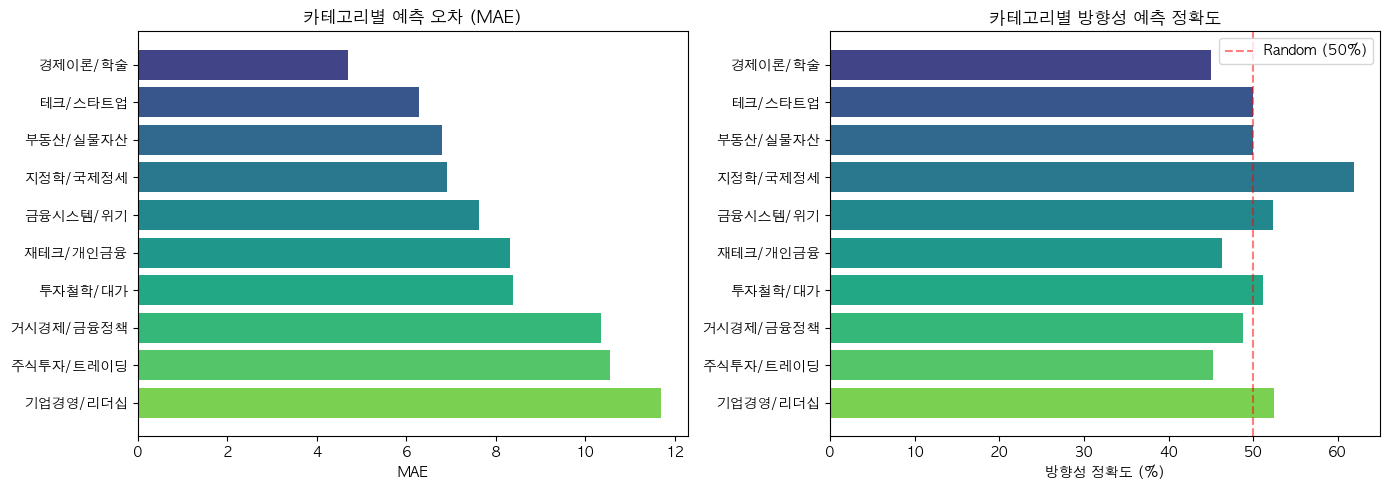

In [10]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 카테고리별 MAE 막대 그래프
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE 막대 그래프
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(df_results)))
bars = ax1.barh(df_results['category'], df_results['mae'], color=colors)
ax1.set_xlabel('MAE')
ax1.set_title('카테고리별 예측 오차 (MAE)')
ax1.invert_yaxis()

# 방향성 정확도 막대 그래프
ax2 = axes[1]
bars2 = ax2.barh(df_results['category'], df_results['direction_accuracy']*100, color=colors)
ax2.set_xlabel('방향성 정확도 (%)')
ax2.set_title('카테고리별 방향성 예측 정확도')
ax2.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
ax2.invert_yaxis()
ax2.legend()

plt.tight_layout()
plt.savefig('prophet_walkforward_decay_performance.png', dpi=150, bbox_inches='tight')
plt.show()

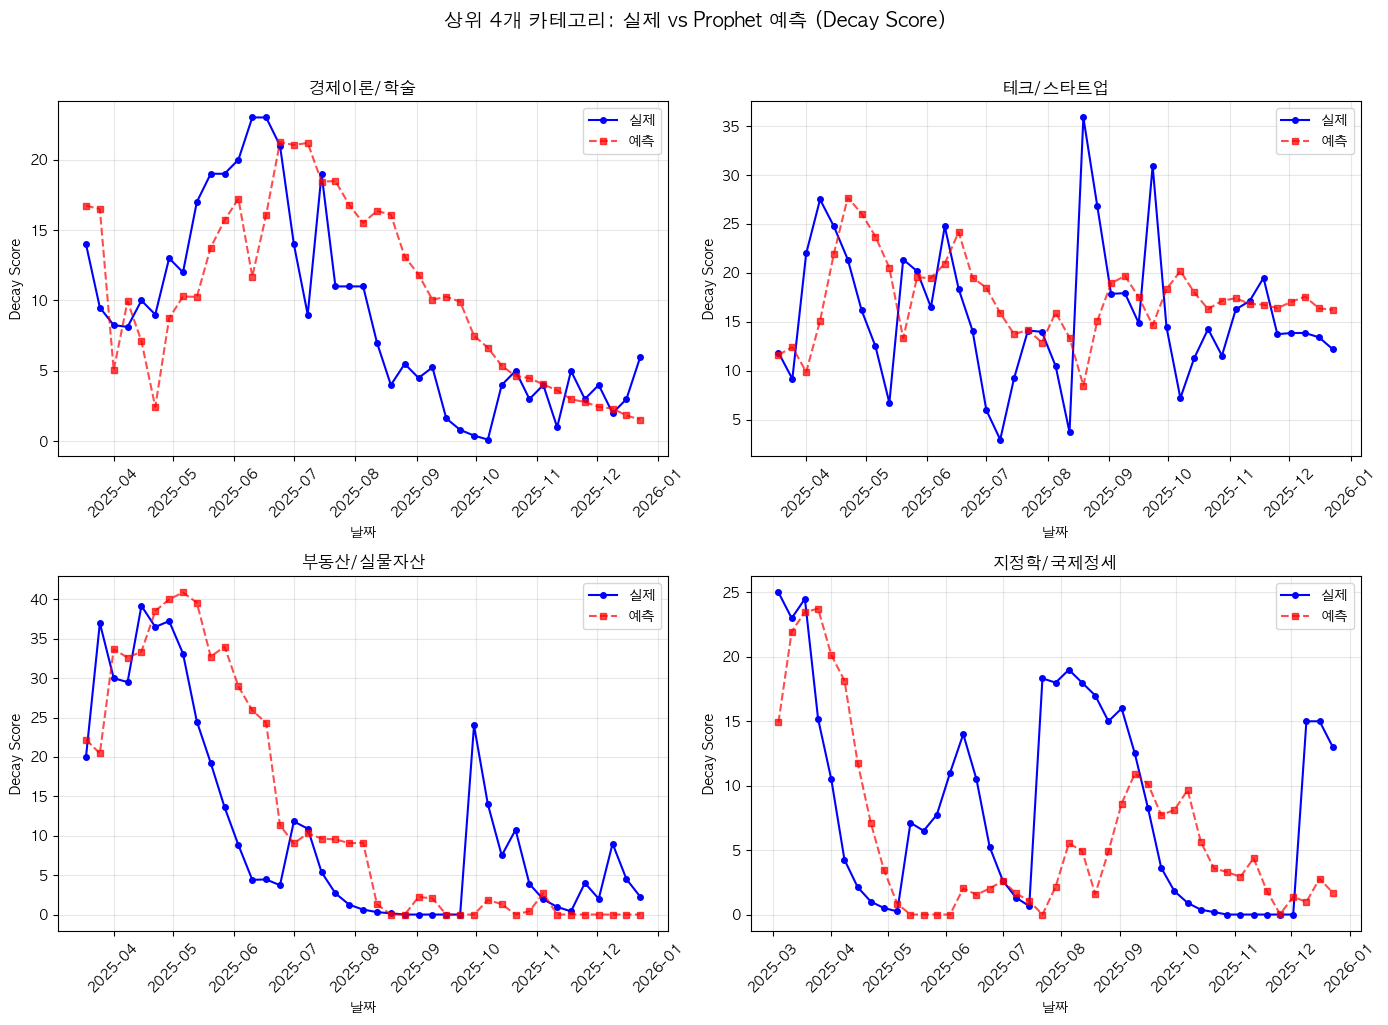

In [11]:
# 상위 4개 카테고리 실제 vs 예측 시계열 그래프
top_categories = df_results.head(4)['category'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, cat in enumerate(top_categories):
    ax = axes[idx]
    cat_data = df_preds[df_preds['category'] == cat].sort_values('ds')
    
    ax.plot(cat_data['ds'], cat_data['actual_score'], 'b-o', label='실제', markersize=4)
    ax.plot(cat_data['ds'], cat_data['prophet_forecast'], 'r--s', label='예측', markersize=4, alpha=0.7)
    
    ax.set_title(f'{cat}')
    ax.set_xlabel('날짜')
    ax.set_ylabel('Decay Score')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.suptitle('상위 4개 카테고리: 실제 vs Prophet 예측 (Decay Score)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('prophet_walkforward_decay_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

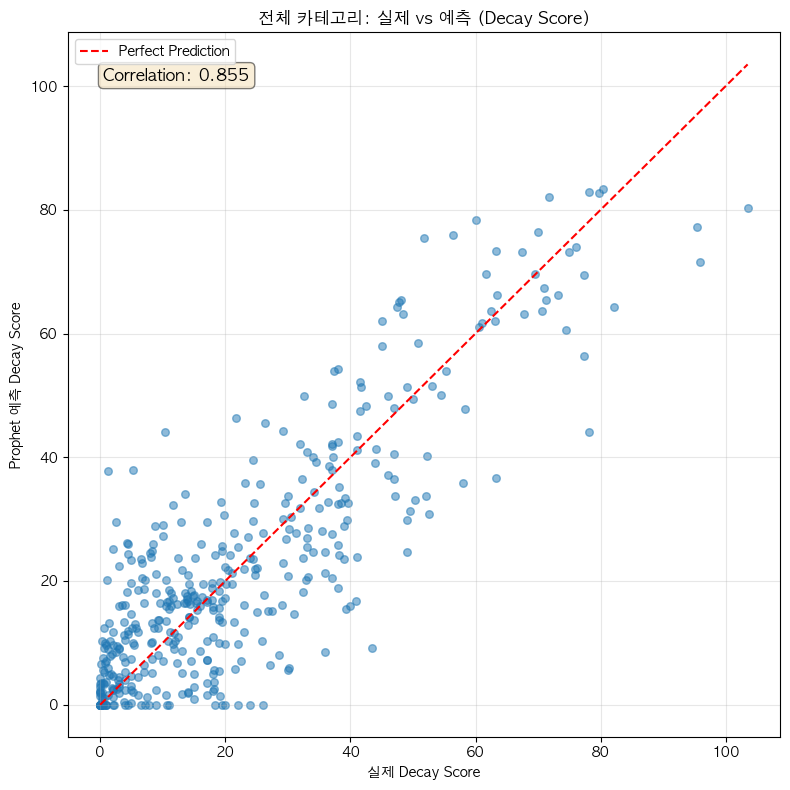


📈 전체 상관계수: 0.8555


In [12]:
# 전체 Scatter Plot (실제 vs 예측)
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(df_preds['actual_score'], df_preds['prophet_forecast'], alpha=0.5, s=30)

# 대각선 (완벽한 예측)
max_val = max(df_preds['actual_score'].max(), df_preds['prophet_forecast'].max())
ax.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')

ax.set_xlabel('실제 Decay Score')
ax.set_ylabel('Prophet 예측 Decay Score')
ax.set_title('전체 카테고리: 실제 vs 예측 (Decay Score)')
ax.legend()
ax.grid(True, alpha=0.3)

# 상관계수
corr = np.corrcoef(df_preds['actual_score'], df_preds['prophet_forecast'])[0, 1]
ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('prophet_walkforward_decay_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📈 전체 상관계수: {corr:.4f}")

## 9. 결론

In [13]:
print("\n" + "="*60)
print("📋 [분석 결론]")
print("="*60)

print(f"""
1. Decay Score 적용 효과:
   - 기존 방식 대비 총점 {((total_decay/total_simple)-1)*100:.1f}% 증가
   - 차트아웃 후에도 점진적 영향력 반영

2. Prophet 예측 성능:
   - 평균 MAE: {df_results['mae'].mean():.2f}
   - 평균 RMSE: {df_results['rmse'].mean():.2f}
   - 평균 방향성 정확도: {df_results['direction_accuracy'].mean()*100:.1f}%

3. 최적 Lag 분포:
""")

lag_dist = df_results['best_lag'].value_counts().sort_index()
for lag, count in lag_dist.items():
    print(f"   - {lag}주 시차: {count}개 카테고리")

print(f"""
4. 가장 예측 정확도 높은 카테고리:
   - {df_results.iloc[0]['category']}: MAE {df_results.iloc[0]['mae']:.2f}, 방향성 {df_results.iloc[0]['direction_accuracy']*100:.1f}%

5. 비즈니스 인사이트:
   - 뉴스 바이럴 지수가 도서 판매에 미치는 시차 효과 확인
   - Decay Score로 장기적 영향력 측정 가능
""")
print("="*60)


📋 [분석 결론]

1. Decay Score 적용 효과:
   - 기존 방식 대비 총점 5.9% 증가
   - 차트아웃 후에도 점진적 영향력 반영

2. Prophet 예측 성능:
   - 평균 MAE: 8.16
   - 평균 RMSE: 10.60
   - 평균 방향성 정확도: 50.3%

3. 최적 Lag 분포:

   - 2주 시차: 3개 카테고리
   - 3주 시차: 3개 카테고리
   - 4주 시차: 4개 카테고리

4. 가장 예측 정확도 높은 카테고리:
   - 경제이론/학술: MAE 4.69, 방향성 45.0%

5. 비즈니스 인사이트:
   - 뉴스 바이럴 지수가 도서 판매에 미치는 시차 효과 확인
   - Decay Score로 장기적 영향력 측정 가능



## 10. 예측력 심층 분석

### 10.1 성능 지표 해석

| 지표 | 값 | 해석 |
|------|-----|------|
| **상관계수 (r)** | **0.855** | 높음 - 전체적인 수준 예측 가능 |
| **R²** | **0.732** | 73% 설명력 |
| MAE | 8.17 | 평균 8점 오차 |
| MAE/평균 | 37% | 보통 수준 |
| **방향성 정확도** | **50.4%** | 랜덤 수준 - 등락 예측 불가 |

### 10.2 상관계수는 높은데 방향성이 50%인 이유

Prophet이 **"기본 수준(baseline)"**은 잘 예측하지만, **"주간 변동"**은 못 맞춤

```
예시:
실제: 30 → 35 → 28 → 32  (등락 반복)
예측: 31 → 31 → 31 → 31  (평균값 근처 유지)

→ 상관계수는 높음 (전체적 수준 비슷)
→ 방향성은 50% (등락을 못 맞춤)
```

### 10.3 Prophet 예측의 한계와 활용

| 용도 | 적합성 | 이유 |
|------|--------|------|
| 카테고리별 **평균 수준** 파악 | ✓ 적합 | r=0.86, R²=0.73 |
| **다음 주 상승/하락** 예측 | ✗ 부적합 | 방향성 50% (랜덤) |
| **장기 트렌드** 파악 | ✓ 적합 | 전체적 패턴 포착 |
| **단기 투자 결정** | ✗ 부적합 | 주간 변동 예측 불가 |

### 10.4 결론

Prophet 예측력은 **"낮다"기보다 "제한적"**이라고 표현하는 것이 정확함:

- ✓ 카테고리별 판매 규모의 **대략적인 수준**은 예측 가능
- ✗ 다음 주에 **상승할지 하락할지**는 예측 불가
- ✗ **뉴스 바이럴 → 도서 판매** 인과관계는 약함